<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap11_4_cnn_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Conv1D,Embedding,GlobalMaxPooling1D
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
path_train = 'https://raw.githubusercontent.com/viniciusrpb/cic0269_natural_language_processing/main/datasets/corpora/tweets_polarity_classification/twitter-2013train-A.txt'
path_test = 'https://raw.githubusercontent.com/viniciusrpb/cic0269_natural_language_processing/main/datasets/corpora/tweets_polarity_classification/twitter-2013test-A.txt'
path_valid = 'https://raw.githubusercontent.com/viniciusrpb/cic0269_natural_language_processing/main/datasets/corpora/tweets_polarity_classification/twitter-2013dev-A.txt'

In [ ]:
df_train = pd.read_csv(path_train,names=['id','polarity','text'],sep='\t')
df_valid = pd.read_csv(path_valid,names=['id','polarity','text'],sep='\t')
df_test = pd.read_csv(path_test,names=['id','polarity','text'],sep='\t')

In [ ]:
df_test

,id,polarity,text
0,264238274963451904,positive,"@jjuueellzz down in the Atlantic city, ventnor..."
1,218775148495515649,positive,Musical awareness: Great Big Beautiful Tomorro...
2,258965201766998017,neutral,On Radio786 100.4fm 7:10 Fri Oct 19 Labour ana...
3,262926411352903682,negative,"Kapan sih lo ngebuktiin,jan ngomong doang Susa..."
4,171874368908050432,neutral,"Excuse the connectivity of this live stream, f..."
...,...,...,...
3542,264233437060288512,negative,Khaleda Zia's present India visit may have a b...
3543,263779058284904448,neutral,"FYI, golf fans: @jameslepp will join Moj on We..."
3544,250744453831213056,negative,@__Aniko you think mr.Calle let practice with ...
3545,258679974591090688,positive,Don't hide under your desk! It's just a salsa ...


In [ ]:
print(f'Train size {df_train.shape}')
print(f'Valid size {df_valid.shape}')
print(f'Test size {df_test.shape}')

Train size (9684, 3)
Valid size (1654, 3)
Test size (3547, 3)


In [ ]:
df_train = df_train.drop(labels=['id'],axis=1)
df_valid = df_valid.drop(labels=['id'],axis=1)
df_test = df_test.drop(labels=['id'],axis=1)

In [ ]:
df_train['polarity'] = pd.Categorical(df_train['polarity'])
y_train_int = df_train['polarity'].cat.codes

df_valid['polarity'] = pd.Categorical(df_valid['polarity'])
y_valid_int = df_valid['polarity'].cat.codes

df_test['polarity'] = pd.Categorical(df_test['polarity'])
y_test_int = df_test['polarity'].cat.codes

In [ ]:
y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

### Numericalização

Determina a quantidade de palavras do *corpus* de treinamento:

In [ ]:
train_tweets = df_train['text'].to_list()

vocabulary = {}

for i in range(0,len(train_tweets)):
    train_tweets[i] = train_tweets[i].lower()
    for word in train_tweets[i].split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word]+=1

Preparando o texto:

In [ ]:
vocab_size = len(vocabulary)
max_length = 32
trunc_type = 'post'
padding_type = 'post'

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'')
tokenizer.fit_on_texts(df_train['text'])

In [ ]:
word_index = tokenizer.word_index

In [ ]:
len(word_index)

23757

In [ ]:
train_sequences = tokenizer.texts_to_sequences(df_train['text'])

In [ ]:
len(train_sequences[0])

15

In [ ]:
len(train_sequences[2])

19

In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
print(df_train['text'][0])
print(train_sequences[0])

Gas by my house hit $3.39!!!! I\u2019m going to Chapel Hill on Sat. :)
[2692, 69, 22, 192, 382, 74, 2891, 4, 58, 31, 2, 1956, 1130, 6, 120]


In [ ]:
valid_sequences = tokenizer.texts_to_sequences(df_valid['text'])
test_sequences = tokenizer.texts_to_sequences(df_test['text'])

valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Arquitetura da Rede Multilayer Perceptron Profunda

Hyperparâmetros da rede

In [ ]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(128, 7, activation='relu'))
#model.add(GlobalMaxPooling1D())
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           3629600   
                                                                 
 conv1d (Conv1D)             (None, 26, 128)           89728     
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 128)           82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

In [ ]:
sgd = SGD(learning_rate=0.01)
model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history_fine = model.fit(train_padded,y_train,validation_data=(valid_padded,y_valid),epochs=30)

Epoch 1/30
303/303 [==============================] - 9s 27ms/step - loss: 1.0230 - accuracy: 0.4663 - val_loss: 1.0594 - val_accuracy: 0.4468
Epoch 2/30
303/303 [==============================] - 14s 46ms/step - loss: 1.0069 - accuracy: 0.4736 - val_loss: 1.0637 - val_accuracy: 0.4468
Epoch 3/30
303/303 [==============================] - 14s 45ms/step - loss: 1.0062 - accuracy: 0.4736 - val_loss: 1.0631 - val_accuracy: 0.4468
Epoch 4/30
303/303 [==============================] - 8s 25ms/step - loss: 1.0058 - accuracy: 0.4736 - val_loss: 1.0618 - val_accuracy: 0.4468
Epoch 5/30
303/303 [==============================] - 8s 25ms/step - loss: 1.0050 - accuracy: 0.4736 - val_loss: 1.0622 - val_accuracy: 0.4468
Epoch 6/30
303/303 [==============================] - 8s 25ms/step - loss: 1.0044 - accuracy: 0.4736 - val_loss: 1.0619 - val_accuracy: 0.4468
Epoch 7/30
303/303 [==============================] - 8s 25ms/step - loss: 1.0035 - accuracy: 0.4736 - val_loss: 1.0621 - val_accuracy: 0.44

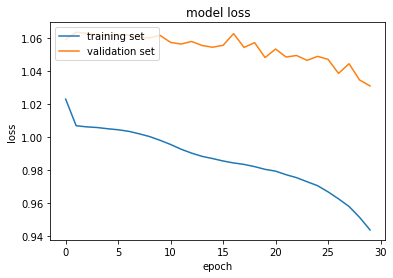

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

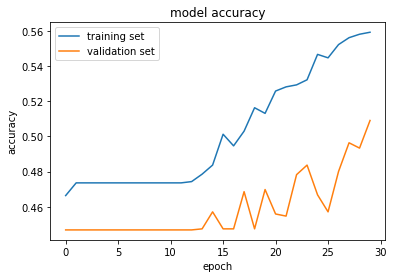

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

Avaliação com os Dados de Teste

In [ ]:
y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)

In [ ]:
print(classification_report(y_test_int,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       559
           1       0.48      0.90      0.63      1513
           2       0.56      0.27      0.36      1475

    accuracy                           0.50      3547
   macro avg       0.35      0.39      0.33      3547
weighted avg       0.44      0.50      0.42      3547



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
